### Multivariate polynomial fit

Using the sequential feature selector

There are $\begin{pmatrix} n+N \\ N \end{pmatrix}$ terms in a polynomial of degree $N$ and $n$ input features.

In this notebook I want to first split the data into cloud regimes, then give the option to transform the features in a smarter way instead of just normalizing them (CDF-transformed)! For the degree 3 polynomial I work only with the ten best features (from the SFS NNs) (plus p for the regimes). After that I run the SFS. If a CDF-transformed variable is picked, then we could approximate that CDF using PySR.

We can use this notebook to:
- Run polynomials, linear models
- Split the data into regimes (data-driven 2-4 regimes, isccp-based) and train on regimes
- Scaling the features: Normalization, No scaling, CDF-scaling

7/5/23: Added the possibility for a non-greedy selection of features. So we are testing all subsets of a certain size!

In [1]:
# 150GB are enough to run the code (if not even 120GB)

In [2]:
import scipy as sp
from scipy import special

print(special.binom(1 + 3, 3)) # Degree 3, one feature

# qubicc
print(special.binom(17 + 3, 3)) # Degree 3
print(special.binom(17 + 2, 2)) # Degree 2

# dyamond
print(special.binom(24 + 3, 3)) # Degree 3
print(special.binom(24 + 2, 2)) # Degree 2

print(special.binom(10 + 3, 3)) # Degree 3, restricted set of inputs
print(special.binom(11 + 3, 3)) # Degree 3, restricted set of inputs

4.0
1140.0
171.0
2925.0
325.0
286.0
364.0


Last runs: <br>
`script=/home/b/b309170/my_work/published_code/grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec3_data-driven_modeling/sec321_linear_models_and_polynomials/multivariate_polynomial_fit_v2`       
`sbatch ~/scripts/run_jupyter.sh $script 1 1 2 0 1 1 10 0 0`    
`sbatch ~/scripts/run_jupyter.sh $script 1 1 2 0 1 2 10 0 0`      
`sbatch ~/scripts/run_jupyter.sh $script 1 1 2 0 1 3 10 0 0`

In [4]:
import os
import gc
import sys
import time
import json
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import itertools

from tensorflow import nn
from tensorflow.keras.models import load_model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from scipy import interpolate
from scipy import misc

sys.path.insert(0, '/home/b/b309170/my_work/workspace_icon-ml/symbolic_regression/')
from functions import differentiate
from functions import append_dict_to_json

# Add path with my_classes to sys.path
sys.path.insert(0, '/home/b/b309170/my_work/workspace_icon-ml/cloud_cover_parameterization/')

# Reloading custom file to incorporate changes dynamically
import my_classes

from my_classes import read_mean_and_std

# ####################################################

# # Default settings (comment out if you run it in an external script!) #!
# sys.argv[1:] = [k for k in range(9)]

# sys.argv[1] = 1 # Transformation
# sys.argv[2] = 1 # Regimes
# sys.argv[3] = 2 # Regime amount
# sys.argv[4] = 0 # DT based on NNs
# sys.argv[5] = 1 # Regime number
# sys.argv[6] = 1 # Degree of polynomial
# sys.argv[7] = 10 # Seed
# sys.argv[8] = 0 # More seeds
# sys.argv[9] = 1 # SFS or not

# sys.argv[9] = 0

# ####################################################

# Set seed (usually set to 10 and False)
seed = int(sys.argv[7])
np.random.seed(seed)
more_seeds = bool(int(sys.argv[8]))

# Timing all cells
print(time.time())

# How shall we transform the data (pick 0,1,2,3)
set_transformation = int(sys.argv[1])
transformation_options = ['off', 'normalized', 'cdf_in_and_out', 'cdf_in_only']
transformation = transformation_options[set_transformation]

regime_types = ['off', 'data_driven', 'isccp_based']
regime_type = regime_types[int(sys.argv[2])]

# Only relevant for regime_type == 'data_driven':
no_of_regimes = int(sys.argv[3]) # [2,3,4]
dt_basis_nn_predictions = bool(int(sys.argv[4])) # DT decomposition based on NN predictions or not

# Which regime should we work with (pick [1, ..., 4] for isccp_based, [1, ..., (no_of_regimes - 1)] for data_driven)
regime = int(sys.argv[5])

# Non-interactive backend
matplotlib.use('PDF')

# Should we use qubicc or dyamond data
data_source = 'dyamond' 

# cl_volume or cl_area
# output_var = sys.argv[1]
output_var = 'cl_area' 

# Degree of the polynomial (<= 3 is possible)
deg = int(sys.argv[6])
# deg = 2

# SFS/Greedy approach (default 1)
greedy = bool(int(sys.argv[9]))

if transformation == 'off':
    subfolder = '%s_data/unnormalized_data'%data_source
elif transformation == 'normalized':
    subfolder = '%s_data/normalized_data'%data_source
elif transformation == 'cdf_in_and_out':
    subfolder = '%s_data/cdf_transformed_data'%data_source
elif transformation == 'cdf_in_only':
    subfolder = '%s_data/cdf_transformed_input_only'%data_source

# JSON output file
if regime_type == 'off':
    outfile = '~/workspace_icon-ml/symbolic_regression/baselines/polynomial_results_v2/%s/without_regimes/polynomial_fit_%s_with_derivatives_degree_%d.json'%(subfolder, output_var, deg)
elif regime_type == 'isccp_based':
    outfile = '~/workspace_icon-ml/symbolic_regression/baselines/polynomial_results_v2/%s/isccp_based_regimes/polynomial_fit_%s_with_derivatives_degree_%d_regime_%d.json'%(subfolder, output_var, deg, regime)
elif regime_type == 'data_driven' and not more_seeds:
    outfile = '~/workspace_icon-ml/symbolic_regression/baselines/polynomial_results_v2/%s/data_driven_regimes/polynomial_fit_%s_with_derivatives_degree_%d_dt_basis_%s_no_of_regimes_%d_regime_%d.json'%(subfolder, output_var, deg, dt_basis_nn_predictions, no_of_regimes, regime)
elif regime_type == 'data_driven' and more_seeds:
    outfile = '~/workspace_icon-ml/symbolic_regression/baselines/polynomial_results_v2/%s/data_driven_regimes/more_seeds/polynomial_fit_%s_with_derivatives_degree_%d_dt_basis_%s_no_of_regimes_%d_regime_%d_seed_%d.json'%(subfolder, output_var, deg, dt_basis_nn_predictions, no_of_regimes, regime, seed)
    
# For non-SFS
PWD = os.environ['HOME'] + '/my_work/published_code/grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec3_data-driven_modeling/sec321_linear_models_and_polynomials'
if not greedy:
    if deg == 1:
        outfile = os.path.join(PWD, 'linear_models/testing_all_feature_subsets/linear_function_fit_cl_area_with_derivatives.json')
    else:
        outfile = os.path.join(PWD, 'polynomials/testing_all_feature_subsets/polynomial_fit_cl_area_with_derivatives_degree_%d.json'%deg)

1689337236.5292313


**Preprocess data**

In [5]:
if data_source == 'qubicc':
    # Load columns of data
    folder_data = '~/workspace_icon-ml/symbolic_regression/data/'

    input_train = np.load(os.path.join(folder_data, 'input_train_with_deriv.npy'))
    input_valid = np.load(os.path.join(folder_data, 'input_valid_with_deriv.npy'))
    output_train = np.load(os.path.join(folder_data, 'output_train_with_deriv.npy'))
    output_valid = np.load(os.path.join(folder_data, 'output_valid_with_deriv.npy'))
    
elif data_source == 'dyamond':
    output_path = os.environ['HOME'] + '/workspace_icon-ml/symbolic_regression/baselines/linear_results_v2/dyamond_data'    
    folder_data = os.environ['HOME'] + '/my_work/icon-ml_data/cloud_cover_parameterization/neighborhood_based_SR_DYAMOND/'
    
    input_data = np.load(os.path.join(folder_data, 'cloud_cover_input_dyamond.npy'))
    if output_var == 'cl_volume':
        output_data = np.load(os.path.join(folder_data, 'cloud_cover_output_dyamond.npy'))
    elif output_var == 'cl_area':
        output_data = np.load(os.path.join(folder_data, 'cloud_area_output_dyamond.npy'))
        
    new_features = ['hus', 'clw', 'cli', 'ta', 'pa', 'zg', 'fr_land', 'U',\
                    'rh', 'ps', 'hus_z', 'hus_zz', 'clw_z', 'clw_zz', 'cli_z',\
                    'cli_zz', 'ta_z', 'ta_zz', 'pa_z', 'pa_zz', 'U_z', 'U_zz',\
                    'rh_z', 'rh_zz']
        
    # If deg == 3: Only use the 10 most important variables (deemed to be most important by the SFS NNs). Otherwise we run into memory issues.
    if deg == 3:
        # To locate variables
        loc = {}
        for i in range(len(new_features)):
            loc[new_features[i]] = i 
        
        # Keeping also pa so that we can put the data into regimes
        selected_features = ['clw', 'cli', 'ta', 'rh', 'ps', 'ta_z', 'pa_z', 'pa_zz', 'rh_z', 'rh_zz', 'pa']
            
        A = np.zeros((input_data.shape[0], len(selected_features)))
        for k in range(len(selected_features)):
            A[:, k] = input_data[:, loc[selected_features[k]]]
            
        input_data = A.copy()
        new_features = selected_features
        
        del A
        gc.collect()
    
    samples_total, no_of_features = input_data.shape
    
    # Split into train/valid
    training_folds = []
    validation_folds = []
    two_week_incr = samples_total//6

    for i in range(3):
        # Note that this is a temporal split since time was the first dimension in the original tensor
        first_incr = np.arange(samples_total//6*i, samples_total//6*(i+1))
        second_incr = np.arange(samples_total//6*(i+3), samples_total//6*(i+4))

        validation_folds.append(np.append(first_incr, second_incr))
        training_folds.append(np.arange(samples_total))
        training_folds[i] = np.delete(training_folds[i], validation_folds[i])
        
    # The second fold yields the best model
    flattened_input_train = input_data[training_folds[1]]
    flattened_input_valid = input_data[validation_folds[1]]
    flattened_output_train = output_data[training_folds[1]]
    flattened_output_valid = output_data[validation_folds[1]]
    
    # Remove input_data, output_data
    del input_data, output_data, training_folds, validation_folds
    gc.collect()

In [6]:
# # MSE that comes from regime 0 [for cl_area there are still some condensate-free clouds in the data set]
# I = np.where(flattened_input_valid[:, 1] + flattened_input_valid[:, 2] == 0)[0]
# M = np.mean(flattened_output_valid[I])

# print('MSE on regime 0: %.4f'%np.mean((flattened_output_valid[I])**2))

# # MSE 
# print('Number of samples in regime 0: %d'%len(I))

In [7]:
if data_source == 'qubicc':
    # Features
    new_features = ['qv', 'qv_z', 'qv_zz', 'qc', 'qc_z', 'qc_zz', 'qi', 'qi_z', 'qi_zz', 'temp', 'temp_z', 'temp_zz', \
                    'pres', 'pres_z', 'pres_zz', 'zg', 'fr_land']

    # To locate variables
    loc = {}
    for i in range(len(new_features)):
        loc[new_features[i]] = i

    # input_train.shape is (100000, 27, 17)
    
    ## Add relative humidity
    pres_train = input_train[:, :, loc['pres']]
    qv = input_train[:, :, loc['qv']]
    temp = input_train[:, :, loc['temp']]

    T0 = 273.15
    r = 0.00263*pres_train*qv*np.exp((17.67*(temp-T0))/(temp-29.65))**(-1)

    new_features.append('rh')
    input_train = np.append(input_train, np.expand_dims(r, -1), axis=2)

    # The same for input_valid
    pres_valid = input_valid[:, :, loc['pres']]
    qv = input_valid[:, :, loc['qv']]
    temp = input_valid[:, :, loc['temp']]

    T0 = 273.15
    r = 0.00263*pres_valid*qv*np.exp((17.67*(temp-T0))/(temp-29.65))**(-1)

    input_valid = np.append(input_valid, np.expand_dims(r, -1), axis=2)
    
    ## Add surface pressure to every sample
    ps_train = np.expand_dims(np.repeat(np.expand_dims(pres_train[:, -1], -1), 27, axis=1), -1)
    ps_valid = np.expand_dims(np.repeat(np.expand_dims(pres_valid[:, -1], -1), 27, axis=1), -1)

    new_features.append('ps')
    input_train = np.append(input_train, ps_train, axis=2)
    input_valid = np.append(input_valid, ps_valid, axis=2)
    
    # Updating loc
    loc = {}
    for i in range(len(new_features)):
        loc[new_features[i]] = i
    
    # input_train.shape is (100000, 27, 19)
    
    # Normalizing the data
    if transformation=='normalized':
        m = np.mean(input_train, axis=(0,1), dtype=np.float64)
        s = np.std(input_train, axis=(0,1), dtype=np.float64)

        input_train = (input_train - m)/s
        input_valid = (input_valid - m)/s
        
    # Flatten before passing it to LinearRegression()
    flattened_input_train = np.reshape(input_train, (-1, len(new_features)))
    flattened_input_valid = np.reshape(input_valid, (-1, len(new_features)))
    flattened_output_train = np.reshape(output_train, -1)
    flattened_output_valid = np.reshape(output_valid, -1)

**Split into cloud regimes**

According to both:
- a*q_i + q_c
- air pressure

--> There is no easy way to specify a, so I choose it to be equal to 1 (alternatively one could think about mean(a qi) = mean(qc)). Then I can interpret qi+qc as the condensate mixing ratio.

So I have four regimes in total: <br>
1) 0 < qi+qc < 1.6e-5 and p < 7.9e4 [High altitude, little condensate]
2) 0 < qi+qc < 1.6e-5 and p > 7.9e4 [Low altitude, little condensate]
3) qi+qc > 1.6e-5 and p < 7.9e4 [High altitude, high condensate]
4) qi+qc > 1.6e-5 and p > 7.9e4 [Low altitude, high condensate]

For $qi + qc = 0$ we simply set $C = 0$.

In every regime there are more than 2.3e6 samples.

In [8]:
# To locate variables
loc = {}
for i in range(len(new_features)):
    loc[new_features[i]] = i

In [9]:
if regime_type == 'isccp_based':
    a = 1

    cod_subs = a*flattened_input_train[:, loc['cli']] + flattened_input_train[:, loc['clw']]
    cod_subs_med = np.median(cod_subs[cod_subs != 0])

    pa_med = np.median(flattened_input_train[cod_subs != 0, loc['pa']])

    # For the training data
    input_train_reg_1 = flattened_input_train[(0 < cod_subs) & (cod_subs < cod_subs_med) & (flattened_input_train[:, loc['pa']] < pa_med)]
    input_train_reg_2 = flattened_input_train[(0 < cod_subs) & (cod_subs < cod_subs_med) & (flattened_input_train[:, loc['pa']] > pa_med)]
    input_train_reg_3 = flattened_input_train[(cod_subs > cod_subs_med) & (flattened_input_train[:, loc['pa']] < pa_med)]
    input_train_reg_4 = flattened_input_train[(cod_subs > cod_subs_med) & (flattened_input_train[:, loc['pa']] > pa_med)]

    output_train_reg_1 = flattened_output_train[(0 < cod_subs) & (cod_subs < cod_subs_med) & (flattened_input_train[:, loc['pa']] < pa_med)]
    output_train_reg_2 = flattened_output_train[(0 < cod_subs) & (cod_subs < cod_subs_med) & (flattened_input_train[:, loc['pa']] > pa_med)]
    output_train_reg_3 = flattened_output_train[(cod_subs > cod_subs_med) & (flattened_input_train[:, loc['pa']] < pa_med)]
    output_train_reg_4 = flattened_output_train[(cod_subs > cod_subs_med) & (flattened_input_train[:, loc['pa']] > pa_med)]

    # Same for the validation data
    cod_subs = a*flattened_input_valid[:, loc['cli']] + flattened_input_valid[:, loc['clw']]

    input_valid_reg_1 = flattened_input_valid[(0 < cod_subs) & (cod_subs < cod_subs_med) & (flattened_input_valid[:, loc['pa']] < pa_med)]
    input_valid_reg_2 = flattened_input_valid[(0 < cod_subs) & (cod_subs < cod_subs_med) & (flattened_input_valid[:, loc['pa']] > pa_med)]
    input_valid_reg_3 = flattened_input_valid[(cod_subs > cod_subs_med) & (flattened_input_valid[:, loc['pa']] < pa_med)]
    input_valid_reg_4 = flattened_input_valid[(cod_subs > cod_subs_med) & (flattened_input_valid[:, loc['pa']] > pa_med)]

    output_valid_reg_1 = flattened_output_valid[(0 < cod_subs) & (cod_subs < cod_subs_med) & (flattened_input_valid[:, loc['pa']] < pa_med)]
    output_valid_reg_2 = flattened_output_valid[(0 < cod_subs) & (cod_subs < cod_subs_med) & (flattened_input_valid[:, loc['pa']] > pa_med)]
    output_valid_reg_3 = flattened_output_valid[(cod_subs > cod_subs_med) & (flattened_input_valid[:, loc['pa']] < pa_med)]
    output_valid_reg_4 = flattened_output_valid[(cod_subs > cod_subs_med) & (flattened_input_valid[:, loc['pa']] > pa_med)]

    # Do the regimes have a similar size?
    for i in range(1, 5):
        print(locals()['input_train_reg_%d'%i].shape)
        print(locals()['output_train_reg_%d'%i].shape)

    # Do the regimes have a similar size?
    for i in range(1, 5):
        print(locals()['input_valid_reg_%d'%i].shape)
        print(locals()['output_valid_reg_%d'%i].shape)

elif regime_type == 'data_driven':
    from sklearn import tree
    
    # Already remove the regime with clw + cli = 0
    reg_not_0_train = np.where(flattened_input_train[:, loc['clw']] + flattened_input_train[:, loc['cli']] != 0)[0]
    flattened_input_train = flattened_input_train[reg_not_0_train]
    flattened_output_train = flattened_output_train[reg_not_0_train]
    
    reg_not_0_valid = np.where(flattened_input_valid[:, loc['clw']] + flattened_input_valid[:, loc['cli']] != 0)[0]
    flattened_input_valid = flattened_input_valid[reg_not_0_valid]
    flattened_output_valid = flattened_output_valid[reg_not_0_valid]
    
    # We only need to split the regimes further if no_of_regimes > 2
    if no_of_regimes > 2:
        # Take a subset of the data to train the decision tree on
        subset_size = 10**7 # or 10**6

        inds = np.random.randint(0, flattened_input_train.shape[0], subset_size)
        input_subset = flattened_input_train[inds]
        output_subset = flattened_output_train[inds]
        
        if dt_basis_nn_predictions:
            # Load SFS cl_area NN with four input features
            custom_objects = {}
            custom_objects['leaky_relu'] = nn.leaky_relu

            path_model = '~/workspace_icon-ml/cloud_cover_parameterization/neighborhood_based_on_seq_feat_sel_DYAMOND/saved_models/hyperparameter_tests/neighborhood_based_sfs_cl_area_no_features_4_False_False_16.txt'
            model = load_model(path_model[:-3]+'h5', custom_objects=custom_objects)

            # Normalize input_subset.
            mean, std = read_mean_and_std(path_model)
            input_subset_scaled = (np.concatenate([np.expand_dims(input_subset[:, loc[sel_var]], axis=1) for sel_var in ['clw', 'cli', 'ta', 'rh']], axis = 1) - mean)/std
            
            Y = model.predict(input_subset_scaled)
        else:
            Y = output_subset.copy()

        classification_tree = tree.DecisionTreeRegressor(max_depth=3, max_leaf_nodes=(no_of_regimes-1)) # set max_depth to [2,3]
        classification_tree.fit(input_subset, Y)
        text_representation = tree.export_text(classification_tree, feature_names=new_features)

        if dt_basis_nn_predictions:
            dt_tree_path = '~/workspace_icon-ml/symbolic_regression/baselines/polynomial_results_v2/%s_data/decision_trees/based_on_nn_preds_%d_regimes.txt'%(data_source, no_of_regimes)
        else:
            dt_tree_path = '~/workspace_icon-ml/symbolic_regression/baselines/polynomial_results_v2/%s_data/decision_trees/based_on_orig_data_%d_regimes.txt'%(data_source, no_of_regimes)

        with open(dt_tree_path, 'w') as file:
            file.write(text_representation)

**Choose the appropriate regime**

In [10]:
if regime_type == 'isccp_based':
    # Convert string into variable name according to the right regime
    flattened_input_train = locals()['input_train_reg_%d'%regime].copy()
    flattened_input_valid = locals()['input_valid_reg_%d'%regime].copy()

    flattened_output_train = locals()['output_train_reg_%d'%regime].copy()
    flattened_output_valid = locals()['output_valid_reg_%d'%regime].copy()
elif regime_type == 'data_driven' and no_of_regimes > 2:
    ind_reg_train = np.where(classification_tree.apply(flattened_input_train) == regime)
    ind_reg_valid = np.where(classification_tree.apply(flattened_input_valid) == regime)
    
    # Sometimes, the regime is called differently...
    if np.sum(ind_reg_train) == 0:
        print('The regime %d does not exist, switching to regime %d instead.'%(regime, no_of_regimes))
        ind_reg_train = np.where(classification_tree.apply(flattened_input_train) == no_of_regimes)
        ind_reg_valid = np.where(classification_tree.apply(flattened_input_valid) == no_of_regimes)
    
    flattened_input_train = flattened_input_train[ind_reg_train]
    flattened_input_valid = flattened_input_valid[ind_reg_valid]

    flattened_output_train = flattened_output_train[ind_reg_train]
    flattened_output_valid = flattened_output_valid[ind_reg_valid]

**Normalize features**

In [11]:
if transformation=='normalized':
    scaler = StandardScaler()
    
    scaler.fit(flattened_input_train)
    
    flattened_input_train = scaler.transform(flattened_input_train)
    flattened_input_valid = scaler.transform(flattened_input_valid)
    
    d = {}
    d['Feature names'] = str(new_features)
    d['Mean'] = str(scaler.mean_)
    d['Variance'] = str(scaler.var_)
    d['Number of validation samples'] = int(np.minimum(flattened_input_valid.shape[0], 2*10**6))
    
    if regime_type == 'data_driven':
        json_outpath = '~/workspace_icon-ml/symbolic_regression/baselines/polynomial_results_v2/%s/scalers_dt_basis_%s_no_of_regimes_%d_regime_%d.json'%(subfolder, dt_basis_nn_predictions, no_of_regimes, regime)
    else:
        json_outpath = '~/workspace_icon-ml/symbolic_regression/baselines/polynomial_results_v2/%s/scalers_regime_%d.json'%(subfolder, regime)
    
    # with open(json_outpath, 'w') as file:
    #     json.dump(d, file)

**Transform features according to CDFs**

The CDF is only computed in an approximative fashion on a regular grid, which is an approximation and could be sensitive to the grid spacing!

In [12]:
def compute_cdf(A, h):
    '''
        This method creates a CDF function based on A and does NOT transform A.
        Note that len(a) = len(b).
    
        A: Vector of values
        h: The values for the CDF are calculated at the points np.min(A) + kh, k in N
        
        Yields:
        a, b: x- and y-values of the CDF
    '''
    a = np.arange(np.min(A), np.max(A)+h, h)

    b = []
    for k in range(len(a)):
        b.append(np.sum(A <= a[k])/len(A))
    
    return a, np.array(b) 

def compute_inverse_cdf(X, a, b):
    '''
        Reconstructs the original values of the vector X (that has values in [0, 1]) 
        based on the CDF which is described by a mapping a -> b.
    
        It holds: len(X) = len(A).
        If (a,b) = compute_cdf(A, h), then compute_inverse_cdf(b, a, b) = a.
    '''
    # Convert to nd-array just in case
    a = np.array(a)
    b = np.array(b)
    
    A = [a[np.argmin(np.abs(X[i] - b))] for i in range(len(X))]
    
    return np.array(A)

# h = (np.max(flattened_input_train[:, loc['hus']]) - np.min(flattened_input_train[:, loc['hus']]))/100
# a, b = compute_cdf(flattened_input_train[:, loc['hus']], h)
# plt.plot(a, b)

In [13]:
# Transform the inputs
if transformation=='cdf_in_and_out' or transformation=='cdf_in_only':
    
    cdf_transformed_train = {key: None for key in loc}
    cdf_transformed_valid = {key: None for key in loc}
    
    # Save x values of the cdf to be able to invert it
    cdf_x_values = {key: None for key in loc}
    cdf_y_values = {key: None for key in loc}

    # 37 seconds per key (have 24 keys) --> 15 minutes
    for key in cdf_transformed_train.keys():
        A = flattened_input_train[:, loc[key]]
        A_val = flattened_input_valid[:, loc[key]]

        # We allow for 100 different values
        h = (np.max(A) - np.min(A))/100   

        # Compute the CDF
        a, b = compute_cdf(A, h)
        
        cdf_x_values[key] = a.tolist()
        cdf_y_values[key] = b.tolist()

        # Find the relevant index
        inds = np.array((A - np.min(A))/h, dtype=int)

        # Same for the validation data
        inds_val = np.array((A_val - np.min(A))/h, dtype=int)

        # For the validation data we could be out of sample so we have to take care of the indices
        inds_val = np.maximum(np.minimum(inds_val, len(b) - 1), 0)

        cdf_transformed_train[key] = b[inds]
        cdf_transformed_valid[key] = b[inds_val]
    
    # Replace the data with the CDF-transformed data
    for key in cdf_transformed_train.keys():
        flattened_input_train[:, loc[key]] = cdf_transformed_train[key]
        flattened_input_valid[:, loc[key]] = cdf_transformed_valid[key]

In [14]:
# # Test 1: Successful

# q = np.array([1,1,2,3,3.5,4])

# # We allow for 100 different values
# h = (max(q) - min(q))/100

# # Compute the CDF
# a, b = compute_cdf(q, h)

# # Find the relevant index
# inds = np.array((q - min(q))/h, dtype=int)

# print(b[inds])
# plt.plot(a,b)

In [15]:
# Transform the output
if transformation=='cdf_in_and_out':

    A = flattened_output_train
    A_val = flattened_output_valid

    # We allow for 100 different values
    h = (np.max(A) - np.min(A))/100

    # Compute the CDF
    a, b = compute_cdf(A, h)
    plt.plot(a, b)

    cdf_x_values[output_var] = a.tolist()
    cdf_y_values[output_var] = b.tolist()
    
    # Find the relevant index
    inds = np.array((A - np.min(A))/h, dtype=int)

    # Same for the validation data
    inds_val = np.array((A_val - np.min(A))/h, dtype=int)

    cdf_transformed_train[output_var] = b[inds]
    cdf_transformed_valid[output_var] = b[inds_val]
    
    # Replace the output data with the CDF-transformed data
    flattened_output_train = cdf_transformed_train[output_var]
    flattened_output_valid = cdf_transformed_valid[output_var]
        
    del cdf_transformed_train, cdf_transformed_valid
    gc.collect()
    
    # # Write this file only if deg = 2, otherwise it will get overwritten for deg = 3 with its fewer input features
    # if deg == 2:
    # To be able to invert the CDF if necessary
    with open('~/workspace_icon-ml/symbolic_regression/baselines/polynomial_results_v2/%s/cdf_x_values_regime_%d.json'%(subfolder, regime), 'w') as file:
        json.dump(cdf_x_values, file)

    with open('~/workspace_icon-ml/symbolic_regression/baselines/polynomial_results_v2/%s/cdf_y_values_regime_%d.json'%(subfolder, regime), 'w') as file:
        json.dump(cdf_y_values, file)

**Best linear model with four features**

The score barely differs at all.

In [18]:
# lin_reg = LinearRegression()
# lin_reg.fit(flattened_input_train[:, [loc['rh'], loc['clw'], loc['cli'], loc['ta']]], flattened_output_train)
# lin_reg.score(flattened_input_valid[:, [loc['rh'], loc['clw'], loc['cli'], loc['ta']]], flattened_output_valid)

0.5545711625803007

In [19]:
# lin_reg = LinearRegression()
# lin_reg.fit(flattened_input_train[:, [loc['rh'], loc['rh_z'], loc['cli'], loc['ta']]], flattened_output_train)
# lin_reg.score(flattened_input_valid[:, [loc['rh'], loc['rh_z'], loc['cli'], loc['ta']]], flattened_output_valid)

0.5511722237713514

**Work only with 2 Mio samples each**

In [270]:
if flattened_input_valid.shape[0] > 2*10**6:
    subs_ind_train = np.random.randint(1, flattened_input_train.shape[0], 2*10**6)
    subs_ind_val = np.random.randint(1, flattened_input_valid.shape[0], 2*10**6)

    flattened_input_train = flattened_input_train[subs_ind_train]
    flattened_output_train = flattened_output_train[subs_ind_train]
    flattened_input_valid = flattened_input_valid[subs_ind_val]
    flattened_output_valid = flattened_output_valid[subs_ind_val]

**Running the feature selector**

For 5 Mio samples max.

In [ ]:
# # For faster testing
# flattened_input_train = flattened_input_train[:1000] #!
# flattened_output_train = flattened_output_train[:1000] #!
# flattened_input_valid = flattened_input_valid[:1000] #!
# flattened_output_valid = flattened_output_valid[:1000] #!

325


/home/b/b309170/my_work/Miniconda3/envs/clouds/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Features selected by non-greedy selector: ['ta', 'rh']


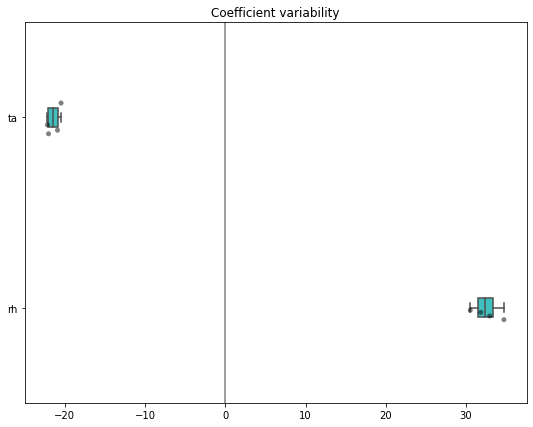

In [272]:
# For cv = 3 and deg = 3 we can do one loop/2 hours
# For cv = 3 and deg = 2 we can do one loop/22 minutes

cv = 2
min_features_to_select = 1 # default: 1 #! 2
max_features_to_select = 6 # default: 11 (= MAX + 1)  #! 4

# Collect all results
dict_combined = {}

# Generate a model of polynomial features
# Turns 19 into 210 features
poly = PolynomialFeatures(degree=deg)
X_train = poly.fit_transform(flattened_input_train)

if deg == 2:
    assert X_train.shape[1] == 1 + len(new_features)/2*(len(new_features)+3)

print(X_train.shape[1])

new_features = poly.get_feature_names(new_features) # Update the feature names
X_valid = poly.fit_transform(flattened_input_valid)

lin_reg = LinearRegression()
for no_features in np.arange(min_features_to_select, max_features_to_select): 
    if greedy:
        sfs = SequentialFeatureSelector(lin_reg, n_features_to_select=no_features, direction='forward', cv=cv, n_jobs=-1)
        sfs.fit(X_train, flattened_output_train)
        selected_features = np.array(new_features)[sfs.get_support()].tolist()
        print(
            "Features selected by forward sequential selection: "
            f"{selected_features}"
        )

        # Plot coefficient variability
        X_transformed = sfs.transform(X_train)        

        cv_model = cross_validate(
            lin_reg,
            X_transformed,
            flattened_output_train,
            cv=RepeatedKFold(n_splits=cv, n_repeats=cv),
            return_estimator=True,
            n_jobs=-1,
        )

    else:
        # Test all possible subsets!
        cv_models = {}
        powerset = list(itertools.combinations(range(X_train.shape[1]), no_features))
        for subset in powerset:
            X_transformed = X_train[:, subset]
            
            cv_models[subset] = cross_validate(
                lin_reg,
                X_transformed,
                flattened_output_train,
                cv=RepeatedKFold(n_splits=cv, n_repeats=cv),
                return_estimator=True,
                n_jobs=-1,
            )
            
        # Choose best subset of features based on the median
        medians = {key: np.median(cv_models[key]['test_score']) for key in cv_models.keys()}
        opt_key = max(medians, key=medians.get)
        selected_features = list(np.array(new_features)[list(opt_key)])

        # Encase in list if necessary
        if type(selected_features) == str:
            selected_features = [selected_features]
        print(
            "Features selected by non-greedy selector: "
            f"{selected_features}"
        )

        cv_model = cv_models[opt_key]
        
    coefs = pd.DataFrame(
        [
            est.coef_
            for est in cv_model["estimator"]
        ],
        columns=selected_features,
    )

    plt.figure(figsize=(9, 7))
    sns.stripplot(data=coefs, orient="h", color="k", alpha=0.5)
    sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, width=.1)
    plt.axvline(x=0, color=".5")
    plt.title("Coefficient variability")

    if regime_type == 'data_driven' and greedy and not more_seeds:
        plt.savefig('~/workspace_icon-ml/symbolic_regression/baselines/polynomial_results_v2/%s/data_driven_regimes/coefs_%d_features_degree_%d_%s_dt_basis_%s_no_of_regimes_%d_regime_%d.pdf'\
                %(subfolder, no_features, deg, output_var, dt_basis_nn_predictions, no_of_regimes, regime))
    elif greedy and not more_seeds:
        plt.savefig('~/workspace_icon-ml/symbolic_regression/baselines/polynomial_results_v2/%s/coefs_%d_features_degree_%d_%s_regime_%d.pdf'\
                %(subfolder, no_features, deg, output_var, regime))
    elif not greedy:
        plt.savefig(outfile[:-5] + '_no_features_%d'%no_features + '.pdf')

    # Predictions of the optimal multiple linear regression model trained on transformed data
    lin_reg.fit(X_transformed, flattened_output_train)

    if greedy:
        Y_transformed = sfs.transform(X_valid)
    else:
        Y_transformed = X_valid[:, opt_key]
        if len(Y_transformed.shape) == 1:
            Y_transformed = np.expand_dims(Y_transformed, 1)

    clc_predictions_train = lin_reg.predict(X_transformed)
    clc_predictions_valid = lin_reg.predict(Y_transformed)

    # We can at least a posteriori enforce the [0, 100] constraint
    if regime_type == 'data_driven':
        clc_predictions_train = np.maximum(np.minimum(clc_predictions_train, 100), 0)
        clc_predictions_valid = np.maximum(np.minimum(clc_predictions_valid, 100), 0)

    if data_source == 'qubicc':    
        ## Remove upper-most two layers to compute R2 values
        input_train_upper_removed = []
        output_train_upper_removed = []
        input_valid_upper_removed = []
        output_valid_upper_removed = []

        assert X_transformed.shape[0] == Y_transformed.shape[0]

        for i in range(X_transformed.shape[0]):
            if not i%27 in [0, 1]:
                input_train_upper_removed.append(X_transformed[i])
                output_train_upper_removed.append(flattened_output_train[i])
                input_valid_upper_removed.append(Y_transformed[i])
                output_valid_upper_removed.append(flattened_output_valid[i])

        input_train_upper_removed = np.array(input_train_upper_removed)
        output_train_upper_removed = np.array(output_train_upper_removed)
        input_valid_upper_removed = np.array(input_valid_upper_removed)
        output_valid_upper_removed = np.array(output_valid_upper_removed)

    # Output function and its R2-score
    dict_exp = {}
    for i in range(len(selected_features)):
        dict_exp[selected_features[i]] = lin_reg.coef_[i]
    dict_exp['Bias'] = lin_reg.intercept_
    # DYAMOND: MSEs and R2 were computed on subsets of no_samples each
    if transformation=='cdf_in_and_out':
        # Inverting the CDF
        clc_predictions_train = compute_inverse_cdf(clc_predictions_train, cdf_x_values[output_var], cdf_y_values[output_var])
        clc_predictions_valid = compute_inverse_cdf(clc_predictions_valid, cdf_x_values[output_var], cdf_y_values[output_var])
        flattened_output_train = compute_inverse_cdf(flattened_output_train, cdf_x_values[output_var], cdf_y_values[output_var])
        flattened_output_valid = compute_inverse_cdf(flattened_output_valid, cdf_x_values[output_var], cdf_y_values[output_var])    
    if data_source == 'qubicc':
        dict_exp['R2 score on training data'] = lin_reg.score(input_train_upper_removed, output_train_upper_removed)
        dict_exp['R2 score on validation data'] = lin_reg.score(input_valid_upper_removed, output_valid_upper_removed)
    elif data_source == 'dyamond':
        # Should be equivalent to lin_reg.score, however, lin_reg.score does not transform the output before comparing it to the truth!
        dict_exp['R2 score on training data (regime)'] = 1 - np.mean((clc_predictions_train - flattened_output_train)**2)/np.var(flattened_output_train)
        dict_exp['R2 score on validation data (regime)'] = 1 - np.mean((clc_predictions_valid - flattened_output_valid)**2)/np.var(flattened_output_valid)

    dict_exp['MSE on training data (regime)'] = mean_squared_error(flattened_output_train, clc_predictions_train)
    dict_exp['MSE on validation data (regime)'] = mean_squared_error(flattened_output_valid, clc_predictions_valid)

    dict_combined['Number of variables %d'%no_features] = dict_exp

    # Write dict_combined to the JSON outfile
    append_dict_to_json(dict_combined, outfile)